In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from pylab import rcParams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression

In [3]:
def wordSplit(rev, stop_words = stopwords.words('English')):
    s = [item for sublist in [f.lower().split() for f in re.findall('\d+|\D+',rev.lower())] for item in sublist]
    s = [x for x in s if x not in stop_words]
    
    return s

def bagOfWordsShingles(review, k=3, stop_words = stopwords.words('English')):
    s = wordSplit(review, stop_words)
    if len(s) < k:
        tokens = ['']
        for s_ in s:
            tokens[0] += s_ + ' '
        tokens[0] = tokens[0][:-1]
        return tokens
        
    tokens = []
    for i in range(len(s) - k + 1):
        bag = ''
        for j in range(i, i + k):
            bag += s[j]+' '
        tokens.append(bag[:-1])
    return tokens

def bagOfWordsShingles2(review, k=3, stop_words = stopwords.words('English')):
    s = wordSplit(review, stop_words)
    tokens = []
    for K in range(0,k):
        for i in range(len(s) - (k-K) + 1):
            bag = ''
            for j in range(i, i + k-K):
                bag += s[j]+' '
            tokens.append(bag[:-1])

    return tokens

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    rcParams['figure.figsize'] = 6, 6
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def train_test_LR(featMap, trueLabels, testSize=.33):
    train, test, train_labels, test_labels = train_test_split(featMap,trueLabels,test_size=testSize,random_state=42)
    train = MaxAbsScaler().fit_transform(train)
    test = MaxAbsScaler().fit_transform(test)
    
    lreg = LogisticRegression(tol=0.001)
    lreg.fit(train,train_labels)
    test_predict = lreg.predict(test)
    
    confMat = confusion_matrix(test_labels,test_predict).astype(float)
    normConfMat = confMat.copy()
    normConfMat[0,:] /= confMat[0,:].sum()
    normConfMat[1,:] /= confMat[1,:].sum()
    return confMat, normConfMat, lreg.score(test, test_labels)

In [5]:
def extractFeatures(englishReviews, wordThreshold = 0):
    thrPosEngRevs = englishReviews.loc[englishReviews['Positive_Processed_Word_Count'] > wordThreshold]['Positive_Review']
    thrNegEngRevs = englishReviews.loc[englishReviews['Negative_Processed_Word_Count'] > wordThreshold]['Negative_Review']

    allReviews = pd.concat([thrPosEngRevs, thrNegEngRevs])
    labels = np.hstack([np.ones(thrPosEngRevs.shape[0]), np.zeros(thrNegEngRevs.shape[0])])
    tfidf = TfidfVectorizer(stop_words=stopwords.words('English'),tokenizer=bagOfWordsShingles2, lowercase=True).fit(allReviews)
    featureMatrix = tfidf.fit_transform(allReviews)
    
    return tfidf, featureMatrix, labels

In [22]:
featureMatrix = sps.load_npz('./Datasets_2/UkReviews_Raw_BOW123_Features.npz')
labels = np.load('./Datasets_2/UkReviews_Raw_BOW123_Labels.npz')['arr_0']

#featureMatrix = sps.load_npz('./Datasets_2/Regression_Features.npz')
#labels = np.load('./Datasets_2/Regression_Labels.npz')['arr_0']

# Select From Model SVC

In [23]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(featureMatrix, labels)
model = SelectFromModel(lsvc, prefit=True)
fm = model.transform(featureMatrix)
print fm.shape
sps.save_npz('Feat_Selection_SVC', fm)

(490492, 2181)


# Select from Model LREG

In [137]:
lsvc = LogisticRegression(C=0.5, penalty="l1", dual=False).fit(featureMatrix, labels)
model = SelectFromModel(lsvc, prefit=True)
fm = model.transform(featureMatrix)
print fm.shape
sps.save_npz('Feat_Selection_LREG', fm)

(490492, 2280)


# Variance Threshold

In [21]:
sel = VarianceThreshold(threshold=2e-5)
fm = sel.fit_transform(featureMatrix)
print fm.shape
sps.save_npz('Feat_Selection_VarThr', fm)

(245246, 6707)


# K Best

In [24]:
fm = SelectKBest(chi2, k=3000).fit_transform(featureMatrix, labels)
print fm.shape
sps.save_npz('Feat_Selection_KBest', fm)

(490492, 3000)


# Train & Test on SVM and LREG

In [136]:
### Until here, you have the dimensionality reduction
### From then on, do your ML algorithm

train, test, train_labels, test_labels = train_test_split(fm,labels,test_size=.33,random_state=42)

lsvc = LinearSVC().fit(train, train_labels)
test_predict = lsvc.predict(test)

cm = confusion_matrix(test_labels,test_predict).astype(float)
cm[0,:] /= cm[0,:].sum()
cm[1,:] /= cm[1,:].sum()

for c in cm:
    print c

lreg = LogisticRegression().fit(train,train_labels)
test_predict = lreg.predict(test)

cm = confusion_matrix(test_labels,test_predict).astype(float)
cm[0,:] /= cm[0,:].sum()
cm[1,:] /= cm[1,:].sum()
for c in cm:
    print c

[ 0.95944774  0.04055226]
[ 0.06682927  0.93317073]
[ 0.95919986  0.04080014]
[ 0.06950245  0.93049755]


Confusion matrix, without normalization
[[ 0.95514711  0.04485289]
 [ 0.08321323  0.91678677]]


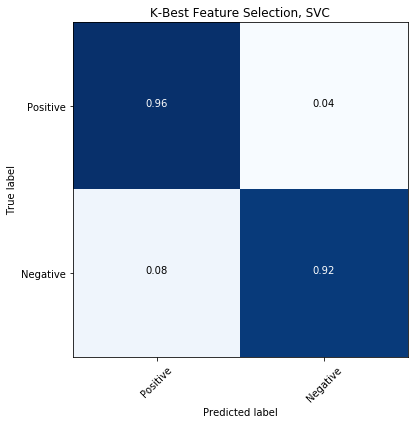

Confusion matrix, without normalization
[[ 0.95468855  0.04531145]
 [ 0.08036759  0.91963241]]


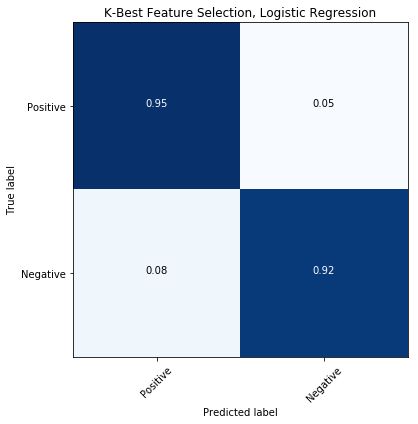

In [32]:
#Chi-Squared
cmLSVC = np.array([[ 0.95514711,  0.04485289],
[ 0.08321323,  0.91678677]])
cmLREG = np.array([[ 0.95468855,  0.04531145],
[ 0.08036759,  0.91963241]])

plot_confusion_matrix(cmLSVC,['Positive','Negative'], title='K-Best Feature Selection, SVC')
plt.tight_layout()
plt.savefig('ChiSquared_LSVC.png')
plt.show()

plot_confusion_matrix(cmLREG,['Positive','Negative'], title='K-Best Feature Selection, Logistic Regression')
plt.tight_layout()
plt.savefig('ChiSquared_LREG.png')
plt.show()

Confusion matrix, without normalization
[[ 0.95698138  0.04301862]
 [ 0.07725095  0.92274905]]


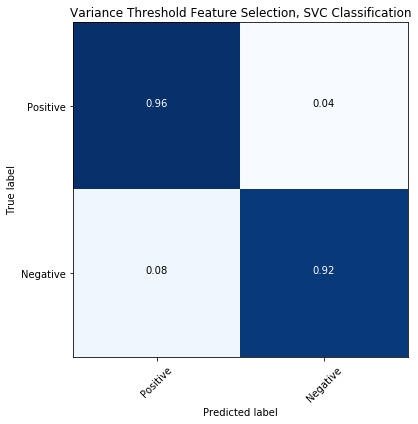

Confusion matrix, without normalization
[[ 0.95551893  0.04448107]
 [ 0.07439299  0.92560701]]


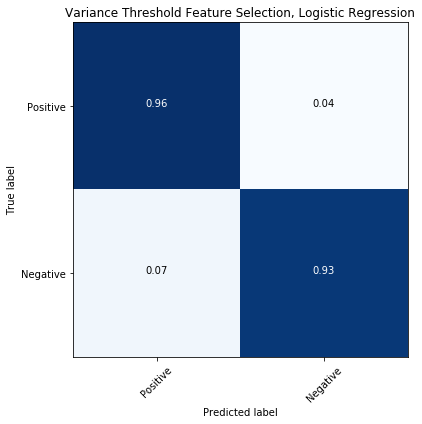

In [33]:
#Variance Threshold
cmLSVC = np.array([[ 0.95698138,  0.04301862],
[ 0.07725095,  0.92274905]])
cmLREG = np.array([[ 0.95551893,  0.04448107],
[ 0.07439299,  0.92560701]])

plot_confusion_matrix(cmLSVC,['Positive','Negative'], title='Variance Threshold Feature Selection, SVC Classification')
plt.tight_layout()
plt.savefig('VarThr_LSVC.png')
plt.show()

plot_confusion_matrix(cmLREG,['Positive','Negative'], title='Variance Threshold Feature Selection, Logistic Regression')
plt.tight_layout()
plt.savefig('VarThr_LREG.png')
plt.show()

Confusion matrix, without normalization
[[ 0.95924944  0.04075056]
 [ 0.06738362  0.93261638]]


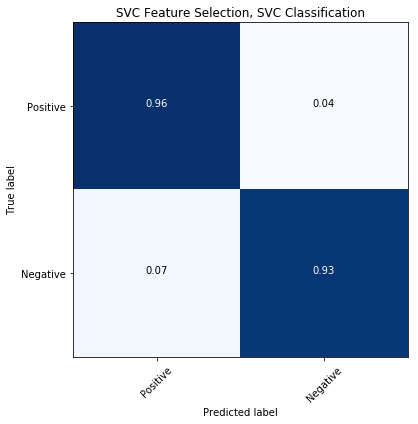

Confusion matrix, without normalization
[[ 0.95910071  0.04089929]
 [ 0.0697365   0.9302635 ]]


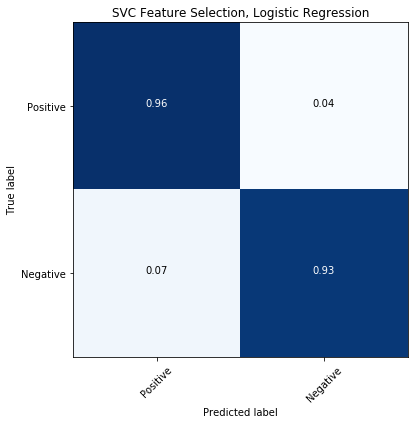

In [34]:
#SVC
cmLSVC = np.array([[ 0.95924944,  0.04075056],
[ 0.06738362,  0.93261638]])
cmLREG = np.array([[ 0.95910071 , 0.04089929],
[ 0.0697365,  0.9302635]])

plot_confusion_matrix(cmLSVC,['Positive','Negative'], title='SVC Feature Selection, SVC Classification')
plt.tight_layout()
plt.savefig('SVC_LSVC.png')
plt.show()

plot_confusion_matrix(cmLREG,['Positive','Negative'], title='SVC Feature Selection, Logistic Regression')
plt.tight_layout()
plt.savefig('SVC_LREG.png')
plt.show()

Confusion matrix, without normalization
[[ 0.95944774  0.04055226]
 [ 0.06682927  0.93317073]]


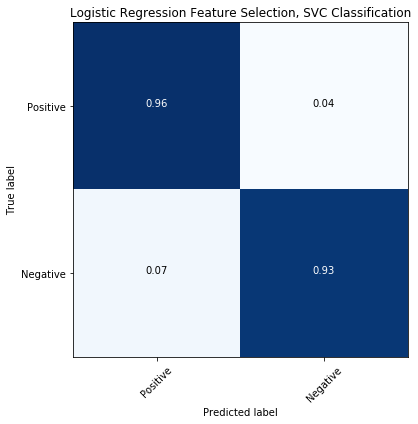

Confusion matrix, without normalization
[[ 0.95919986  0.04080014]
 [ 0.06950245  0.93049755]]


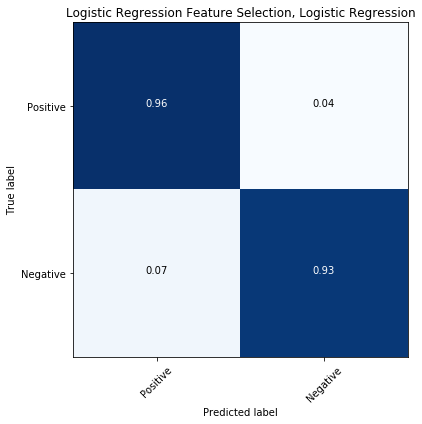

In [35]:
#Lreg
cmLSVC = np.array([[ 0.95944774,  0.04055226],
[ 0.06682927,  0.93317073]])
cmLREG = np.array([[ 0.95919986,  0.04080014],
[ 0.06950245,  0.93049755]])
                  
plot_confusion_matrix(cmLSVC,['Positive','Negative'], title='Logistic Regression Feature Selection, SVC Classification')
plt.tight_layout()
plt.savefig('LREG_LSVC.png')
plt.show()

plot_confusion_matrix(cmLREG,['Positive','Negative'], title='Logistic Regression Feature Selection, Logistic Regression')
plt.tight_layout()
plt.savefig('LREG_LREG.png')
plt.show()